## Decision making in low-rank recurrent neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn

#plt.style.use('dark_background')

# For debugging we will use the below inside some functions.
torch.autograd.set_detect_anomaly(True)
        

### Perceptual decision makingg

__1. Create a function for generating the data.__

In [2]:
# defining standard deviation and strength of stimulus
std = 0.03
stim_strength = std * np.hstack((-np.flip(2**np.arange(0,5)), 2**np.arange(0,5)))


In [3]:

def generate_data(trials, length, stim_strength, std = 0.03):
    """
    ksi is a normally distr noise with sigma 0.03.
    u is an input
    û is the stimulis strength
    y is the target, i.e. the sign of û. 
    y's first dimension is trials and second is length. 
    """
    ksi = std * np.random.randn(trials, length)
    
  
    û_value = np.random.choice(stim_strength, trials)
    û = np.full_like(ksi, 0)
    y = np.full_like(ksi, 1)
    for i in range(trials):
        û[i, 5:46] = û_value[i]
        y[i] = np.sign(û_value[i]) * y[i]
    
    return  torch.from_numpy(û + ksi), torch.from_numpy(y)


In [4]:
# generate data

T = 80
trials = 5
u, y = generate_data(trials, T, stim_strength)
time = np.arange(0,T)


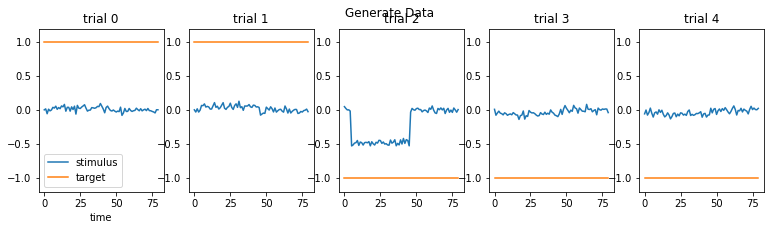

In [5]:
# plot

fig, axs = plt.subplots(1, trials, figsize=(13,3))

fig.suptitle("Generate Data")

for i in range(trials):
    axs[i].plot(time, u[i,:], label="stimulus")
    axs[i].plot(time, y[i,:], label="target")
    axs[i].set_title(f"trial {i}")
    axs[i].set_ylim(-1.2, 1.2)
axs[0].set_xlabel("time")
axs[0].legend()
plt.show()

__2. Implement the recurrent neural network in your favorite deep learning library.__

J matrix has to have two trainable vectors m, and n as parameters.

In [ ]:
# TODO: vectorize input and targets and all into batch of time and trials.

In [6]:

def dynamics(x, u, tau, m,n,I):
    J_of_phi_x = 1/len(n)*torch.mv(torch.matmul(m, n), torch.tanh(x.reshape(-1)))
    return (1/tau *(-x + J_of_phi_x.reshape(N,1) + u*I.reshape(N,1)))


In [7]:

class LR_RNN(nn.Module):
    # Low-rank recurrent neural network without readout.
    def __init__(self, N):
        super().__init__()
        # storign info
        self.N = N
        
        # pattern from witch connectivity is made
        tensor_m = torch.randn(N).reshape(N,1)
        self.m = nn.Parameter(tensor_m)
        
        # pattern to which connectivity is made
        tensor_n = torch.randn(N).reshape(1,N)
        self.n = nn.Parameter(tensor_n)
        
        # input weights
        self.I = torch.randn(N)
        
        # Output is defined separetly in different class below.

          
    def forward(self, x, u, tau, dt):
        # It's an Euler method.
        return x + dynamics(x, u, tau, self.m, self.n, self.I) * dt
   

In [15]:
class Model(nn.Module):
    def __init__(self, N):
        super().__init__()
        # storing info
        self.N = N
        
        # the layer
        
        self.lr_rnn = LR_RNN(N)
        
        # output layer
        std_dev = 4
        self.w = std_dev*torch.randn(N).reshape(1, N)
        

    
    def forward(self, x: torch.Tensor, u, tau, dt):
        
        """
        Going forward with the low rank rnn and input.
        Reading through electrode weights.
        """
        x = self.lr_rnn(x, u, tau, dt)

        torch.autograd.set_detect_anomaly(True)
        
        z = 1/self.N * torch.matmul(self.w, torch.tanh(x))
        return x, z
        

In [19]:
# Initialize.

N = 64
x = torch.zeros([N,1])
tau = 0.1  # seconds
dt = 0.02  # seconds


# generate data
T = 75
time = np.arange(0,T)
trials = 8
u, y = generate_data(trials, T, stim_strength)
model = Model(N)

In [21]:
"""
Training:

Backprop is called after computing the error on the whole batch.

"""

epochs = 1
error_record = []
mse_loss = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

for epoch in range(epochs):
    for batch in range(32):

        z_trials = torch.zeros([trials, 15])
        target = torch.zeros([trials, 15])

        for trial_nr in range(trials):
            trial_error = []
            x = torch.zeros([model.N,1])
            for t in range(T-15):

                x = model.lr_rnn.forward(x, u[0, t], tau, dt)

            for k in range(15):

                # Initializations.
                t= T-15+k        

                # Computation and storage of results.
                
                x, z = model.forward(x, u[0, t], tau, dt)
                z.squeeze_()
                z_trials[trial_nr, k] = z.float()
                target[trial_nr, k] = y[trial_nr, T-15+k].float()

                
        # use the error or mse.
        loss = mse_loss(z_trials, target)

        optimizer.zero_grad()  # Reset the gradient values.

        loss.backward()  # Compute the gradients.

        optimizer.step()  # Parameters update.

        
        x = x.detach()  # Free from the past??


        error_record.append(loss.clone().detach())
        print(loss)

    print("epoch ", epoch,"------------", " trial mean error")

tensor(1.0097, grad_fn=<MseLossBackward>)
tensor(1.0078, grad_fn=<MseLossBackward>)
tensor(1.0061, grad_fn=<MseLossBackward>)
tensor(1.0046, grad_fn=<MseLossBackward>)
tensor(1.0032, grad_fn=<MseLossBackward>)
tensor(1.0021, grad_fn=<MseLossBackward>)
tensor(1.0011, grad_fn=<MseLossBackward>)
tensor(1.0004, grad_fn=<MseLossBackward>)
tensor(0.9998, grad_fn=<MseLossBackward>)
tensor(0.9995, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBackward>)
tensor(0.9997, grad_fn=<MseLossBac

Why $x$ should be set to zero after each trial?

In [22]:
for parameter in model.parameters():
    print(parameter.size())

torch.Size([64, 1])
torch.Size([1, 64])
